In [1]:
using JLD2
using FileIO
using PyPlot
using Statistics
using StatsBase 
using Distributions
using LinearAlgebra
using HDF5
using IntervalSets
using Random, ArraysOfArrays
using ValueShapes
using Measurements
using BAT
using DSP
using ForwardDiff

In [2]:
FPATH = "../../data/sampling_results/Benchmark-5/"

function marg_mean_shaped(name)
    smpl_tmp = bat_read(FPATH*name)
    smpl_tmp = varshape(prior).(smpl_tmp)
    smpl_tmp = mean(smpl_tmp)
    return smpl_tmp
end

function marg_std_shaped(name)
    smpl_tmp = bat_read(FPATH*name)
    smpl_tmp = varshape(prior).(smpl_tmp)
    smpl_tmp = std(smpl_tmp)
    return smpl_tmp
end

function get_emmitance_halo(name, proj)
    # proj  1 / 2 
    smpl_tmp = bat_read(FPATH*name)
    smpl_tmp = varshape(prior).(smpl_tmp)
    smpl_tmp, smpl_w = flatview(unshaped.(smpl_tmp.v)), smpl_tmp.weight
    emm = smpl_tmp[proj,:].*smpl_tmp[4+proj,:].*10^-5 .* 1000 .* 426.0
    μ = mean(emm, FrequencyWeights(smpl_w))
    σ = std(emm, FrequencyWeights(smpl_w)) 
    return (mean = μ, std = σ)
end

function get_emmitance_core(name, proj)
    # proj  1 / 2 
    smpl_tmp = bat_read(FPATH*name)
    smpl_tmp = varshape(prior).(smpl_tmp)
    smpl_tmp, smpl_w = flatview(unshaped.(smpl_tmp.v)), smpl_tmp.weight
    emm = smpl_tmp[2+proj,:].*smpl_tmp[6+proj,:].*10^-5 .* 1000 .* 426.0
    μ = mean(emm, FrequencyWeights(smpl_w))
    σ = std(emm, FrequencyWeights(smpl_w)) 
    return (mean = μ, std = σ)
end

get_emmitance_core (generic function with 1 method)

In [3]:
β1 = 0.015
β2 = 0.0077
β3 = 0.0058

# flat prior for the pixel size
prior = NamedTupleDist(
        tr_size = [truncated(Normal(0.2, 0.04), 0.06, 0.19), truncated(Normal(0.2, 0.04), 0.06, 0.19)],
        tr_size_2 = [truncated(Normal(0.2, 0.04), 0.06, 0.19), truncated(Normal(0.2, 0.04), 0.06, 0.19)],
        ang_spr = [truncated(Normal(4.0, 2.0), 4.0, 7.0), truncated(Normal(4.0, 2.0), 4.0, 7.0)],
        ang_spr_2 = [truncated(Normal(4.0, 2.0), 1.0, 4.0), truncated(Normal(4.0, 2.0), 1.0, 4.0)],
        mixt_pow =  0.50 .. 1.0 ,
        waist = [truncated(Normal(2.9, 0.03), 2.65, 3.5)],
        waist_2 = [truncated(Normal(2.9, 0.03), 2.65, 3.5)], # 11
        algmx = [23.0 .. 48, 23.0 .. 48.0, 10.0 .. 30.0, 23.0 .. 48.0],
        algmy = [23.0 .. 48, 23.0 .. 48.0, 10.0 .. 30.0, 23.0 .. 48.0],
        cam4_ped = 4.0 .. 40.0,
        cam4_light_fluct = 1.0 .. 3.0,
        cam4_light_amp = 1.6 .. 9.9, 
        resx = [1, 1, 1], # 23, 24, 25, 
        resy = [1, 1, 1], # 26,27, 28, 
        cam4_resx = truncated(Normal(3, 1.5), 0, Inf),
        cam4_resy = truncated(Normal(3, 1.5), 0, Inf), 
        psx = [27.1, 21.6, 114.0], # 31, 32, 33
        psy = [30.5, 23.4, 125.0], # 34, 35, 36
        cam4_psx = 121.8, # 37
        cam4_psy = 120.0, # 38
        light_amp  = [1.0 .. 13.0 , 1.0 .. 17.0, 1.0 .. 5.0], # 1.0 .. 5.0
        s_cam = [0.0, 1.478, 15.026, 23.1150],
    )


labels = [L"\sigma_x", L"\sigma_y", L"\sigma_x", L"\sigma_y", L"\sigma'_x", L"\sigma'_y", L"\sigma'_x", L"\sigma'_y", L"\alpha", L"s", L"s", 
    L"\mu_x", L"\mu_x", L"\mu_x", L"\mu_x", L"\mu_y", L"\mu_y", L"\mu_y", L"\mu_y", 
    "ped", "lf", "a", "res x", "res y", "la", "la", "la"];

In [4]:
smpl_tmp = bat_read(FPATH*"hc-2.hdf5")
smpl_tmp = varshape(prior).(smpl_tmp);

In [5]:
filenames = readdir("../../data/sampling_results/Benchmark-5/")
images = load("../../data/experiment/dataset_2/m2/images-satur.jld2")
hc_mask = [i[1:3] == "hc-" for i in filenames]
hc_fnames = filenames[hc_mask]
hc_eind = parse.(Int64, [i[4:end-5] for i in hc_fnames])
hc_charge = images["charge"][hc_eind]
hc_runind = images["ev_ind"][hc_eind];

In [6]:
filenames = readdir("../../data/sampling_results/Benchmark-5/")
images = load("../../data/experiment/dataset_2/m1/images-satur.jld2")
lc_mask = [i[1:3] == "lc-" for i in filenames]
lc_fnames = filenames[lc_mask]
lc_eind = parse.(Int64, [i[4:end-5] for i in lc_fnames])
lc_charge = images["charge"][lc_eind]
lc_runind = images["ev_ind"][lc_eind];

In [7]:
fnames = [lc_fnames; hc_fnames]
charges = Float64[lc_charge; hc_charge]
runind = Int64[lc_runind ; hc_runind]
charges_n = charges ./ maximum(charges)
runind_n = runind ./ maximum(runind);

In [8]:
length(fnames)

600

In [9]:
mean_params =  [marg_mean_shaped(i) for i in fnames];
std_params =  [marg_std_shaped(i) for i in fnames];

### Alignment: 

In [10]:
zc_x = [minimum([i.algmx[j] for i in mean_params]) for j in 1:4]; # find min position at each camera 
zc_y = [minimum([i.algmy[j] for i in mean_params]) for j in 1:4]; # find min position at each camera 

In [11]:
x_event = Array{Float64,1}[]
y_event = Array{Float64,1}[]
x_event_std = Array{Float64,1}[]
y_event_std = Array{Float64,1}[]

for i in eachindex(mean_params) 
    push!(x_event, (mean_params[i].algmx .- zc_x) .* [mean_params[i].psx ; mean_params[i].cam4_psx] .+ 1.0 )
    push!(y_event, (mean_params[i].algmy .- zc_y) .* [mean_params[i].psy ; mean_params[i].cam4_psy] .+ 1.0 )
    
    push!(x_event_std, std_params[i].algmx .* [mean_params[i].psx ; mean_params[i].cam4_psx])
    push!(y_event_std, std_params[i].algmy .* [mean_params[i].psy ; mean_params[i].cam4_psy])
     
end

### Emittance: 

In [12]:
emm_tmp_1 = [get_emmitance_halo(i, 1) for i in fnames]
emm_tmp_2 = [get_emmitance_halo(i, 2) for i in fnames];

In [13]:
emm_tmp_21 = [get_emmitance_core(i, 1) for i in fnames]
emm_tmp_22 = [get_emmitance_core(i, 2) for i in fnames];

### Summary File: 

In [14]:
summary_data = (
    
    ev_index = runind,
    ev_charge = charges,
    mode = [i > 15 ? "LP" : "SP" for i in charges],
    
    #fnames = fnames,
    
    μx_trsz_halo = Float64[i.tr_size[1] for i in mean_params],
    μy_trsz_halo = Float64[i.tr_size[2] for i in mean_params],
    
    μx_trsz_core = Float64[i.tr_size_2[1] for i in mean_params],
    μy_trsz_core = Float64[i.tr_size_2[2] for i in mean_params],
    
    μx_angspr_halo = Float64[i.ang_spr[1] for i in mean_params],
    μy_angspr_halo = Float64[i.ang_spr[2] for i in mean_params],
    
    μx_angspr_core = Float64[i.ang_spr_2[1] for i in mean_params],
    μy_angspr_core = Float64[i.ang_spr_2[2] for i in mean_params],
    
    μ_waist_halo = Float64[i.waist[1] for i in mean_params],
    μ_waist_core = Float64[i.waist_2[1] for i in mean_params],
    
    μx_emitt_halo = Float64[i.mean for i in emm_tmp_1],
    μy_emitt_halo = Float64[i.mean for i in emm_tmp_2],
    
    μx_emitt_core = Float64[i.mean for i in emm_tmp_21],
    μy_emitt_core = Float64[i.mean for i in emm_tmp_22],
    
    μmixt_pow = Float64[i.mixt_pow[1] for i in mean_params],
    
    μx_align = x_event,
    μy_align = y_event,
    
    σx_trsz_halo = Float64[i.tr_size[1] for i in std_params],
    σy_trsz_halo = Float64[i.tr_size[2] for i in std_params],
    
    σx_trsz_core = Float64[i.tr_size_2[1] for i in std_params],
    σy_trsz_core = Float64[i.tr_size_2[2] for i in std_params],
    
    σx_angspr_halo = Float64[i.ang_spr[1] for i in std_params],
    σy_angspr_halo = Float64[i.ang_spr[2] for i in std_params],
    
    σx_angspr_core = Float64[i.ang_spr_2[1] for i in std_params],
    σy_angspr_core = Float64[i.ang_spr_2[2] for i in std_params],
        
    σ_waist_halo = Float64[i.waist[1] for i in std_params],
    σ_waist_core = Float64[i.waist_2[1] for i in std_params],
    
    σx_emitt_halo = Float64[i.std for i in emm_tmp_1],
    σy_emitt_halo = Float64[i.std for i in emm_tmp_2],
    
    σx_emitt_core = Float64[i.std for i in emm_tmp_21],
    σy_emitt_core = Float64[i.std for i in emm_tmp_22],
    
    σx_align = x_event_std,
    σy_align = y_event_std,
    
    σmixt_pow =  Float64[i.mixt_pow[1] for i in std_params],
);



# Mean event SP:

In [15]:
mask_tmp = summary_data.mode .== "SP"

mean_event_sp = (
    ev_charge = [mean(summary_data.ev_charge[mask_tmp])],
    
    μx_trsz_halo = [mean(summary_data.μx_trsz_halo[mask_tmp])],
    μy_trsz_halo = [mean(summary_data.μy_trsz_halo[mask_tmp])],
    
    μx_trsz_core = [mean(summary_data.μx_trsz_core[mask_tmp])],
    μy_trsz_core = [mean(summary_data.μy_trsz_core[mask_tmp])],
    
    μx_angspr_halo = [mean(summary_data.μx_angspr_halo[mask_tmp])],
    μy_angspr_halo = [mean(summary_data.μy_angspr_halo[mask_tmp])],
    
    μx_angspr_core = [mean(summary_data.μx_angspr_core[mask_tmp])],
    μy_angspr_core = [mean(summary_data.μy_angspr_core[mask_tmp])],
    
    μ_waist_halo = [mean(summary_data.μ_waist_halo[mask_tmp])],
    μ_waist_core = [mean(summary_data.μ_waist_core[mask_tmp])],
    
    μx_emitt_halo = [mean(summary_data.μx_emitt_halo[mask_tmp])],
    μy_emitt_halo = [mean(summary_data.μy_emitt_halo[mask_tmp])],
    
    μx_emitt_core = [mean(summary_data.μx_emitt_core[mask_tmp])],
    μy_emitt_core = [mean(summary_data.μy_emitt_core[mask_tmp])],
    
    μmixt_pow = [mean(summary_data.μmixt_pow[mask_tmp])],
    
    μx_align = [mean(summary_data.μx_align[mask_tmp], )],
    μy_align = [mean(summary_data.μy_align[mask_tmp], )],
    
    σx_trsz_halo = [mean(summary_data.σx_trsz_halo[mask_tmp])],
    σy_trsz_halo = [mean(summary_data.σy_trsz_halo[mask_tmp])],
    
    σx_trsz_core = [mean(summary_data.σx_trsz_core[mask_tmp])],
    σy_trsz_core = [mean(summary_data.σy_trsz_core[mask_tmp])],
    
    σx_angspr_halo = [mean(summary_data.σx_angspr_halo[mask_tmp])],
    σy_angspr_halo = [mean(summary_data.σy_angspr_halo[mask_tmp])],
    
    σx_angspr_core = [mean(summary_data.σx_angspr_core[mask_tmp])],
    σy_angspr_core = [mean(summary_data.σy_angspr_core[mask_tmp])],
        
    σ_waist_halo = [mean(summary_data.σ_waist_halo[mask_tmp])],
    σ_waist_core = [mean(summary_data.σ_waist_core[mask_tmp])],
    
    σx_emitt_halo = [mean(summary_data.σx_emitt_halo[mask_tmp])],
    σy_emitt_halo = [mean(summary_data.σy_emitt_halo[mask_tmp])],
    
    σx_emitt_core = [mean(summary_data.σx_emitt_core[mask_tmp])],
    σy_emitt_core = [mean(summary_data.σy_emitt_core[mask_tmp])],
    
    σx_align = [mean(summary_data.σx_align[mask_tmp])],
    σy_align = [mean(summary_data.σy_align[mask_tmp])],
    
    σmixt_pow =   [mean(summary_data.σmixt_pow[mask_tmp])],
)

(ev_charge = [9.055577543698824], μx_trsz_halo = [0.04813184975959644], μy_trsz_halo = [0.10401734764055855], μx_trsz_core = [0.0975175228772343], μy_trsz_core = [0.10717296056731117], μx_angspr_halo = [6.471212898552154], μy_angspr_halo = [5.926850477614658], μx_angspr_core = [2.2781418172637267], μy_angspr_core = [2.2002799859545394], μ_waist_halo = [3.075852245069713], μ_waist_core = [2.8481678675351487], μx_emitt_halo = [1.3186919430380113], μy_emitt_halo = [2.621637211663672], μx_emitt_core = [0.9464934440472321], μy_emitt_core = [1.0052195772860573], μmixt_pow = [0.542519284953361], μx_align = [[99.93831915927223, 98.16436440916463, 131.16313209214323, 171.03348999859628]], μy_align = [[53.72249146184398, 36.629096840696995, 90.16745678839976, 113.07053220419238]], σx_trsz_halo = [0.00386201156686948], σy_trsz_halo = [0.0020562532146419276], σx_trsz_core = [0.0010788922276312942], σy_trsz_core = [0.0014582045919904574], σx_angspr_halo = [0.06101154969631992], σy_angspr_halo = [0.

# Mean event LP:

In [16]:
mask_tmp = summary_data.mode .== "LP"

mean_event_lp = (
    ev_charge = [mean(summary_data.ev_charge[mask_tmp])],
    
    μx_trsz_halo = [mean(summary_data.μx_trsz_halo[mask_tmp])],
    μy_trsz_halo = [mean(summary_data.μy_trsz_halo[mask_tmp])],
    
    μx_trsz_core = [mean(summary_data.μx_trsz_core[mask_tmp])],
    μy_trsz_core = [mean(summary_data.μy_trsz_core[mask_tmp])],
    
    μx_angspr_halo = [mean(summary_data.μx_angspr_halo[mask_tmp])],
    μy_angspr_halo = [mean(summary_data.μy_angspr_halo[mask_tmp])],
    
    μx_angspr_core = [mean(summary_data.μx_angspr_core[mask_tmp])],
    μy_angspr_core = [mean(summary_data.μy_angspr_core[mask_tmp])],
    
    μ_waist_halo = [mean(summary_data.μ_waist_halo[mask_tmp])],
    μ_waist_core = [mean(summary_data.μ_waist_core[mask_tmp])],
    
    μx_emitt_halo = [mean(summary_data.μx_emitt_halo[mask_tmp])],
    μy_emitt_halo = [mean(summary_data.μy_emitt_halo[mask_tmp])],
    
    μx_emitt_core = [mean(summary_data.μx_emitt_core[mask_tmp])],
    μy_emitt_core = [mean(summary_data.μy_emitt_core[mask_tmp])],
    
    μmixt_pow = [mean(summary_data.μmixt_pow[mask_tmp])],
    
    μx_align = [mean(summary_data.μx_align[mask_tmp], )],
    μy_align = [mean(summary_data.μy_align[mask_tmp], )],
    
    σx_trsz_halo = [mean(summary_data.σx_trsz_halo[mask_tmp])],
    σy_trsz_halo = [mean(summary_data.σy_trsz_halo[mask_tmp])],
    
    σx_trsz_core = [mean(summary_data.σx_trsz_core[mask_tmp])],
    σy_trsz_core = [mean(summary_data.σy_trsz_core[mask_tmp])],
    
    σx_angspr_halo = [mean(summary_data.σx_angspr_halo[mask_tmp])],
    σy_angspr_halo = [mean(summary_data.σy_angspr_halo[mask_tmp])],
    
    σx_angspr_core = [mean(summary_data.σx_angspr_core[mask_tmp])],
    σy_angspr_core = [mean(summary_data.σy_angspr_core[mask_tmp])],
        
    σ_waist_halo = [mean(summary_data.σ_waist_halo[mask_tmp])],
    σ_waist_core = [mean(summary_data.σ_waist_core[mask_tmp])],
    
    σx_emitt_halo = [mean(summary_data.σx_emitt_halo[mask_tmp])],
    σy_emitt_halo = [mean(summary_data.σy_emitt_halo[mask_tmp])],
    
    σx_emitt_core = [mean(summary_data.σx_emitt_core[mask_tmp])],
    σy_emitt_core = [mean(summary_data.σy_emitt_core[mask_tmp])],
    
    σx_align = [mean(summary_data.σx_align[mask_tmp])],
    σy_align = [mean(summary_data.σy_align[mask_tmp])],
    
    σmixt_pow =   [mean(summary_data.σmixt_pow[mask_tmp])],
)

(ev_charge = [25.98485633156516], μx_trsz_halo = [0.08267953889059604], μy_trsz_halo = [0.12680734828036747], μx_trsz_core = [0.1259435008616752], μy_trsz_core = [0.13924431079222138], μx_angspr_halo = [5.9721193809982855], μy_angspr_halo = [5.598640585351831], μx_angspr_core = [2.4097832380759323], μy_angspr_core = [2.2591025569480543], μ_waist_halo = [3.1924349372255514], μ_waist_core = [2.858929968858487], μx_emitt_halo = [2.098947189597884], μy_emitt_halo = [3.0218403485010352], μx_emitt_core = [1.2944816219719752], μy_emitt_core = [1.3429319404938402], μmixt_pow = [0.6915333010563312], μx_align = [[105.54606344254937, 105.59352629570395, 133.50998851566672, 124.91844531397301]], μy_align = [[55.398693911069145, 39.80956982173046, 104.33986271347626, 122.66211976198392]], σx_trsz_halo = [0.002140934486609566], σy_trsz_halo = [0.001714234726943718], σx_trsz_core = [0.0012173498140700875], σy_trsz_core = [0.002104993943936277], σx_angspr_halo = [0.037750938313276965], σy_angspr_halo 

## Save data: 

In [17]:
# Save data: 

data_save = (summary_data, mean_event_sp, mean_event_lp);

# @save "../../data/sampling_results/Benchmark-5/mcmc-summary-data.jld" data_save

In [18]:
# Load file to update angles:  

# To do: How to average correctly measurements with uns. 

# @load "../../src/Benchmark-5/mcmc-summary-data-tmp.jld" data_save
# (summary_data, mean_event_sp, mean_event_lp) = data_save ;

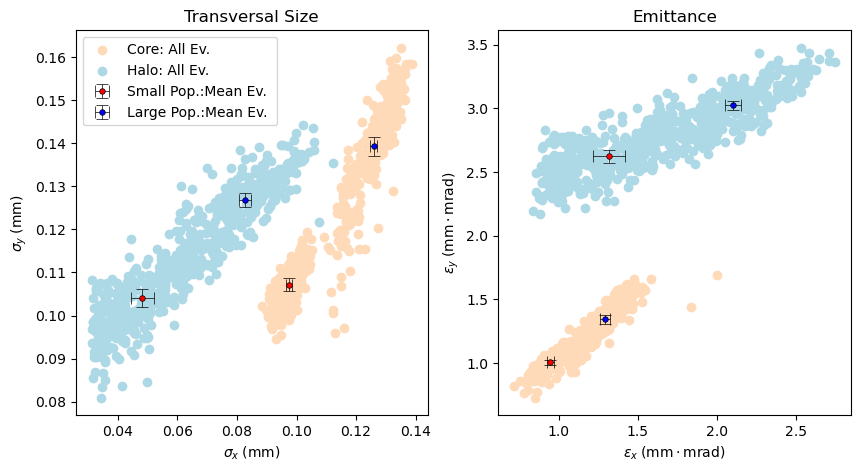

PyObject <matplotlib.legend.Legend object at 0x7fc538ff8910>

In [19]:
fig, ax= plt.subplots(1,2, figsize=(10,5))

ax[1].scatter(summary_data.μx_trsz_core, summary_data.μy_trsz_core, color="peachpuff", label="Core: All Ev.")
ax[2].scatter(summary_data.μx_emitt_core, summary_data.μy_emitt_core, color="peachpuff")

ax[1].scatter(summary_data.μx_trsz_halo, summary_data.μy_trsz_halo, color="lightblue", label="Halo: All Ev.")
ax[2].scatter(summary_data.μx_emitt_halo, summary_data.μy_emitt_halo, color="lightblue")

ax[1].errorbar(
    mean_event_sp.μx_trsz_core, 
    mean_event_sp.μy_trsz_core,
    xerr=mean_event_sp.σx_trsz_core,
    yerr=mean_event_sp.σy_trsz_core,
    color="k", 
    fmt="o", markersize=4,  markeredgewidth=0.5,
    mfc="red", capsize=4, ecolor="k", elinewidth=0.5, label="Small Pop.:Mean Ev. ")

ax[1].errorbar(
    mean_event_lp.μx_trsz_core, 
    mean_event_lp.μy_trsz_core,
    xerr=mean_event_lp.σx_trsz_core,
    yerr=mean_event_lp.σy_trsz_core,
    color="k", 
    fmt="o", markersize=4,  markeredgewidth=0.5,
    mfc="blue", capsize=4, ecolor="k", elinewidth=0.5, label="Large Pop.:Mean Ev. ")

ax[1].errorbar(
    mean_event_sp.μx_trsz_halo, 
    mean_event_sp.μy_trsz_halo,
    xerr=mean_event_sp.σx_trsz_halo,
    yerr=mean_event_sp.σy_trsz_halo,
    color="k", 
    fmt="o", markersize=4,  markeredgewidth=0.5,
    mfc="red", capsize=4, ecolor="k", elinewidth=0.5)

ax[1].errorbar(
    mean_event_lp.μx_trsz_halo, 
    mean_event_lp.μy_trsz_halo,
    xerr=mean_event_lp.σx_trsz_halo,
    yerr=mean_event_lp.σy_trsz_halo,
    color="k", 
    fmt="o", markersize=4,  markeredgewidth=0.5,
    mfc="blue", capsize=4, ecolor="k", elinewidth=0.5)


ax[2].errorbar(
    mean_event_sp.μx_emitt_core, 
    mean_event_sp.μy_emitt_core,
    xerr=mean_event_sp.σx_emitt_core,
    yerr=mean_event_sp.σy_emitt_core,
    color="k", 
    fmt="o", markersize=4,  markeredgewidth=0.5,
    mfc="red", capsize=4, ecolor="k", elinewidth=0.5, label="Small Pop.:Mean Ev. ")

ax[2].errorbar(
    mean_event_lp.μx_emitt_core, 
    mean_event_lp.μy_emitt_core,
    xerr=mean_event_lp.σx_emitt_core,
    yerr=mean_event_lp.σy_emitt_core,
    color="k", 
    fmt="o", markersize=4,  markeredgewidth=0.5,
    mfc="blue", capsize=4, ecolor="k", elinewidth=0.5, label="Small Pop.:Mean Ev. ")

ax[2].errorbar(
    mean_event_sp.μx_emitt_halo, 
    mean_event_sp.μy_emitt_halo,
    xerr=mean_event_sp.σx_emitt_halo,
    yerr=mean_event_sp.σy_emitt_halo,
    color="k", 
    fmt="o", markersize=4,  markeredgewidth=0.5,
    mfc="red", capsize=4, ecolor="k", elinewidth=0.5, label="Small Pop.:Mean Ev. ")

ax[2].errorbar(
    mean_event_lp.μx_emitt_halo, 
    mean_event_lp.μy_emitt_halo,
    xerr=mean_event_lp.σx_emitt_halo,
    yerr=mean_event_lp.σy_emitt_halo,
    color="k", 
    fmt="o", markersize=4,  markeredgewidth=0.5,
    mfc="blue", capsize=4, ecolor="k", elinewidth=0.5, label="Small Pop.:Mean Ev. ")



ax[1].set_title("Transversal Size")
ax[2].set_title("Emittance")

ax[1].set_xlabel(L"\sigma_x \; (\mathrm{mm})")
ax[1].set_ylabel(L"\sigma_y \; (\mathrm{mm})")

ax[2].set_xlabel(L"\epsilon_x \; (\mathrm{mm \cdot mrad})")
ax[2].set_ylabel(L"\epsilon_y \; (\mathrm{mm \cdot mrad})")

ax[1].legend()

In [20]:
# using DataFrames, CSV

# df = DataFrame(summary_data)
# df_sp = DataFrame(mean_event_sp)
# df_lp = DataFrame(mean_event_lp)

# CSV.write("all-events.csv", df)
# CSV.write("sp-mean.csv", df_sp)
# CSV.write("lp-mean.csv", df_lp)